In [11]:
# !pip3 install pandas matplotlib #pdpipe

In [5]:
import os
import glob
import pandas as pd
# import pdpipe as pdp
# pipeline = pdp.ColDrop('Medals').OneHotEncode('Born')
# pipeline(df)

# from collections import Counter
pd.options.mode.chained_assignment = None  # default='warn'

In [12]:
def filter_null(df, column):
    return df[df[column].notna()]

def filter_not_in_prefix(df, prefixes):
    return df[~df['word'].str.startswith(tuple((p+'-' for p in prefixes)))]

def save(df, file):
    df.to_csv(file)
    return df

def read_file(file):
    with open(file, "r") as f:
        return f.read()

def replace_by_list(text, arr, to=''):
    for s in arr:
        text = text.replace(s, to)
    return text

def load_data_calgary(path):
    return ' '.join((read_file(file) for file in glob.glob(path)))

def text_to_words(text):
    return pd.DataFrame(text.split(), columns=['word'])

def filter_in(df, column, arr):
    return df[~df[column].isin(arr)]

def filter_length_more_then(df, column, min_length):
    return df[df[column].str.len() > min_length]

def get_first_letter(df, column):
    df[column] = df['word'].str.lower().str[0]
    return df

def count(df, column, to):
    return df.groupby(column).size().reset_index(name=to)

def sort(df, column):
    return df.sort_values(by=column, ascending=False).reset_index(drop=True) 

def load_data_node(path, usecols=None):
    return pd.read_csv(path, 
                       delimiter=';',
                       na_filter= True,
                       usecols=usecols
                      )

def rename_columns(df, mapper):
    return df.rename(mapper, axis='columns')

def set_index(df, column):
    return df.set_index(column)

,letter,text,dict,dict with prefix,prefix
0,g,13587,2981,9637,6656
1,s,13578,5261,5261,0
2,w,12025,3473,3473,0
3,h,11082,4853,4853,0
4,f,8949,4888,5874,986
5,m,7875,2088,2088,0
6,þ,7254,1261,1261,0
7,b,6989,3882,5083,1201
8,l,4954,1783,1783,0
9,d,4303,1719,1719,0


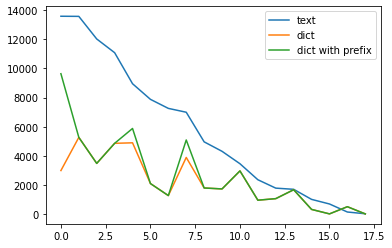

In [13]:
path_corpus = '../../OE_data/texts/'
path = path_corpus + 'calgary/*.txt'
stop_words = read_file('stop_words.txt').split()
word = 'word'
letter = 'letter'
counts = 'text'
dummy_letters = ['#', '.', ';', '!', ':', '(', ')', '?', '\'', '\"', ',', '-']
vouwels = ['o', 'a', 'e', 'i', 'æ', 'u','á', 'ǽ', 'é', 'í', 'ó', 'ú', 'ý'] #, '-', '('

load_texts = (
    text_to_words(
        replace_by_list(
            load_data_calgary(path),
            dummy_letters
        )
    )
)
# print(load_texts)

def pipe_count(df, letter, counts, vouwels):
    return (df
        .pipe(filter_length_more_then, word, 1)
        .pipe(get_first_letter, letter)
        .pipe(filter_in, letter, vouwels)
        .pipe(count, letter, counts)
        .pipe(sort, counts)
        .pipe(set_index, letter)
    )

df_texts = (
    load_texts
    .pipe(filter_in, word, stop_words)
    .pipe(pipe_count, letter, counts, vouwels)
)
# print(pipe_texts)
# print(f'filtred: {len(load_texts) - len(pipe_texts)}')

path = path_corpus + 'BT/node.csv'
column = 'title'
counts = 'dict'
prefixes = ['ge', 'on', 'be', 'ofer', 'a', 'for']

load_dict = (
    load_data_node(path, [column])
    .pipe(rename_columns, {column: word})
    .pipe(filter_null, word)
#     .pipe(save, 'out_not_in_prefix.csv')
)

df_dict = (
    load_dict
    .pipe(filter_not_in_prefix, prefixes)
    .pipe(pipe_count, letter, counts, vouwels)
)

counts = 'dict with prefix'

df_dict_with_prefix = (
    load_dict
    .pipe(pipe_count, letter, counts, vouwels)    
)

res = pd.concat([
    df_texts, 
    df_dict,   
    df_dict_with_prefix
], axis=1, join='inner').reset_index()

res.plot()

res['prefix'] = res['dict with prefix'] - res['dict']
save(res, 'out_count.csv')

res